### TalTech Spectrogram

#### Testing spectograms on data

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import taltech_helpers as h # contains the computations
import numpy as np
import pandas as pd
import json
from scipy.signal import correlate
from scipy.signal import medfilt, butter, filtfilt, lfilter, sosfiltfilt, find_peaks, find_peaks_cwt,resample, detrend
from scipy.signal import stft, spectrogram, get_window
import matplotlib.patches as mpatches
from scipy.signal.windows import hann
import math

In [2]:
# velocity prior to contact time
# contact time may be similar -> there could be something in this -> impact velocity

In [3]:
# read in all the clean data
base = "../../data/clean/"
data = h.read_in_clean_taltech_data(base)

reading taltech data files from ../../data/clean/
['baseline', 'flight']
['exp1', 'exp2']
['barefoot', 'shoes']
['barefoot', 'shoes']
['exp1', 'exp2']
['barefoot', 'shoes']
['barefoot', 'shoes']


In [4]:
exp = 1 # not used yet

In [15]:
def build_filter(frequency, sample_rate, filter_type, filter_order, sos=False):
    #nyq = 0.5 * sample_rate
    if filter_type == "band":
        if(sos):
            sos =  butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='sos', fs=sample_rate)
            return sos
        else:
            #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
            b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
            return b,a
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1], btype=filter_type, analog=False, output='ba', fs=sample_rate)
        return b,a
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)
        return b,a


def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)

def filter_signal_by_sos(sos, signal):
    return sosfiltfilt(sos, signal)


def condition_an_axis(signal_df, f_params):
    #convert to numpy array
    s = signal_df.to_numpy()
    # filter the signal
    sos = build_filter((f_params["lc_off"], f_params["hc_off"]), 
                       f_params["sampling_rate"],
                       f_params["filter_type"], f_params["filter_order"], 
                       sos=True)
    s_filtered = filter_signal_by_sos(sos, s)
    # remove the median
    median_value = np.median(s_filtered)
    signal_centered = s_filtered - median_value
    return signal_centered

def condition_magnitude(x,y,z, f_params):

    mag = h.vector_magnitude([x, y, z])
    # filter the signal
    sos = build_filter((f_params["lc_off"], f_params["hc_off"]), 
                       f_params["sampling_rate"],
                       f_params["filter_type"], f_params["filter_order"], 
                       sos=True)
    filtered_mag = filter_signal_by_sos(sos, mag)
    # remove the median
    median_value = np.median(filtered_mag)
    signal_centered = filtered_mag - median_value
    return signal_centered

def compute_hf_vibration_signal(df, f_params, use_mag=False):
    a_x = df["X"]
    a_y = df["Y"]
    a_z = df["Z"]

    if(use_mag):
        accel_x = a_x.to_numpy()  
        accel_y = a_y.to_numpy()  
        accel_z = a_z.to_numpy()  
    
        # not use the magnitue - introduces noise
        mag = condition_magnitude(accel_x, accel_y, accel_z, f_params)
        
        return mag
    else:
        x_conditioned = condition_an_axis(a_x, f_params)
        y_conditioned = condition_an_axis(a_y, f_params)
        z_conditioned = condition_an_axis(a_z, f_params)

        return [x_conditioned, y_conditioned, z_conditioned]

In [16]:
filter_params = {
    "sampling_rate" : 6600,
    "lc_off" : 100,
    "hc_off" : 2000,
    "filter_order" : 5,
    "filter_type" : "band",
    "freq_min" : 100, # used as masks for diplaying frequency response
    "freq_max" : 2000,
}

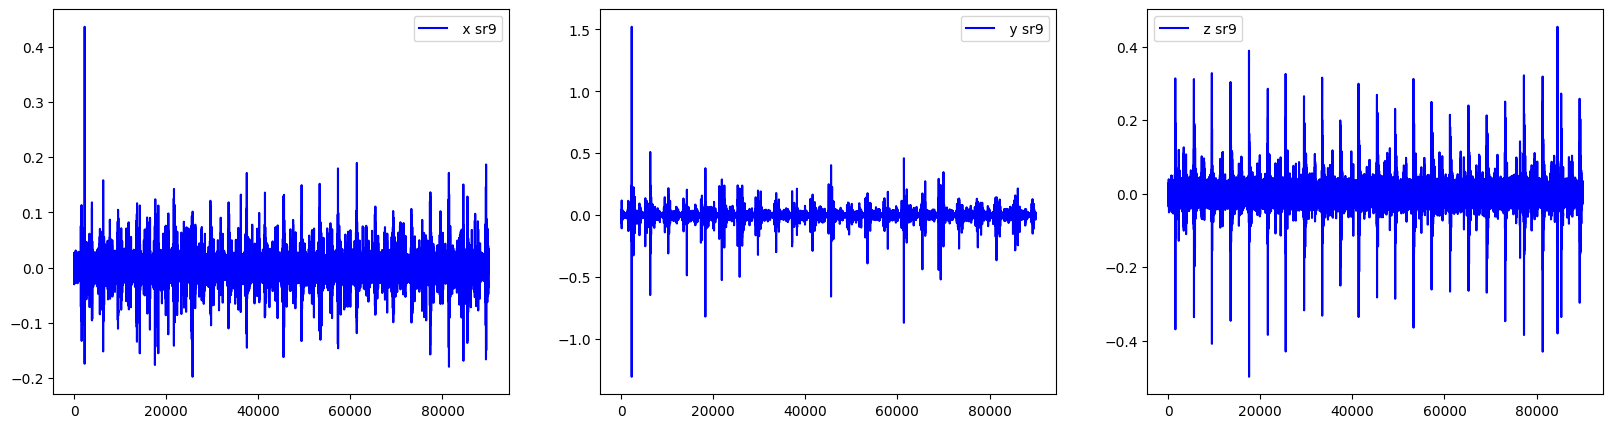

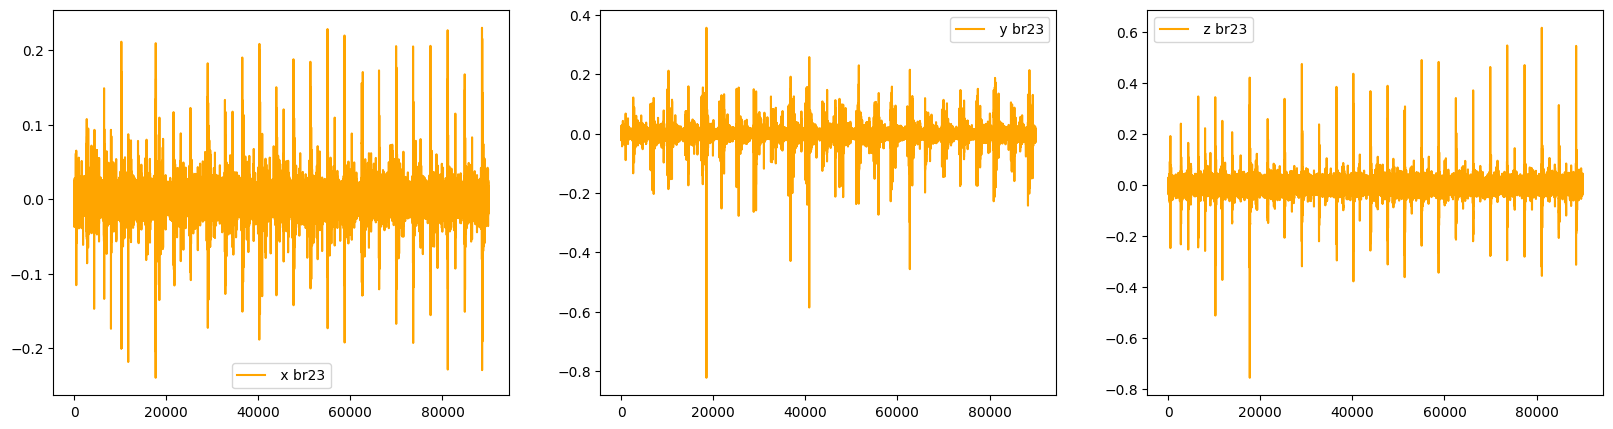

In [17]:
def amplitude_normal(signal):
    sig = np.array(signal)
    data_min = min(sig)
    data_max = max(sig)
    normal = (sig - data_min) / (data_max - data_min)
    return normal.tolist()

def minmax_normalize(signal):
    sig = np.array(signal)
    data_min = np.min(sig)
    data_max = np.max(sig)
    return (2 * (sig - data_min) / (data_max - data_min) - 1).tolist()
    
env = "flight"
exp = 2
#s = "sw5"
#b = "bw19"
#s= "sr9"#"sw5"
#b="br23"
s="sr9"
b="br23"

#s = "sj11"
#b = "bj24"

df_s = data[env][f"exp{str(exp)}"]["shoes"][s]
df_b = data[env][f"exp{str(exp)}"]['barefoot'][b]

use_mag = False
s_sig = compute_hf_vibration_signal(df_s, filter_params, use_mag=use_mag)
b_sig = compute_hf_vibration_signal(df_b, filter_params, use_mag=use_mag)

if(use_mag):
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax.plot(s_sig, color="blue", label=f"{s}")
    ax.legend()
    ax.set_ylim(-0.5, 0.5)

    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax.plot(b_sig, color="orange", label=f"{b}")
    ax.set_ylim(-0.5, 0.5)
    ax.legend()
else:
    fig, ax = plt.subplots(1,3, figsize=(20, 5))
    ax[0].plot(s_sig[0], color="blue", label=f" x {s}")
    ax[0].legend()
    ax[1].plot(s_sig[1], color="blue", label=f" y {s}")
    ax[1].legend()
    ax[2].plot(s_sig[2], color="blue", label=f" z {s}")
    ax[2].legend()

    fig, ax = plt.subplots(1,3, figsize=(20, 5))
    ax[0].plot(b_sig[0], color="orange", label=f" x {b}")
    ax[0].legend()
    ax[1].plot(b_sig[1], color="orange", label=f" y {b}")
    ax[1].legend()
    ax[2].plot(b_sig[2], color="orange", label=f" z {b}")
    ax[2].legend()

In [18]:
#some more helpers
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power

# power spectrum in decibels.
def compute_power(Zxx):
    pwr = np.abs(Zxx)**2
    p_Zxx = 10 * np.log10(np.abs(Zxx) ** 2)
    #p_Zxx = 10 * np.log10(pwr+ 1e-20) # add small value to avoid divide by zero
    return p_Zxx

def compute_stft(signal, fs, window, seg_len, overlap, nfft):
    f, t, Zxx = stft(signal, fs=fs, window=window,  nperseg=seg_len, noverlap=overlap, nfft=nfft)
    p_Zxx = compute_power(Zxx)
    return [f,t,p_Zxx]

In [25]:
# spectogram of s_sig and b_sig

#next fft points value int(math.pow(2, math.ceil(math.log2(len(data)))))
nperseg = 1024  #8192 # Number of samples per segment
overlap = nperseg // 2 # 50 % overlaps
window = hann(nperseg)
nfft = 1024     # FFT points

print(f"frequency resolution {filter_params['sampling_rate']/nperseg}")
print(f"time resolution {nperseg/filter_params['sampling_rate']}")

# returns f,t,p_Zxx
if(use_mag):
    s_stft = compute_stft(s_sig, filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    b_stft = compute_stft(b_sig, filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
else:
    s_stft_x = compute_stft(s_sig[0], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    s_stft_y = compute_stft(s_sig[1], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    s_stft_z = compute_stft(s_sig[2], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)

    b_stft_x = compute_stft(b_sig[0], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    b_stft_y = compute_stft(b_sig[1], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    b_stft_z = compute_stft(b_sig[2], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)

frequency resolution 6.4453125
time resolution 0.15515151515151515


NameError: name 'b_stft_x' is not defined

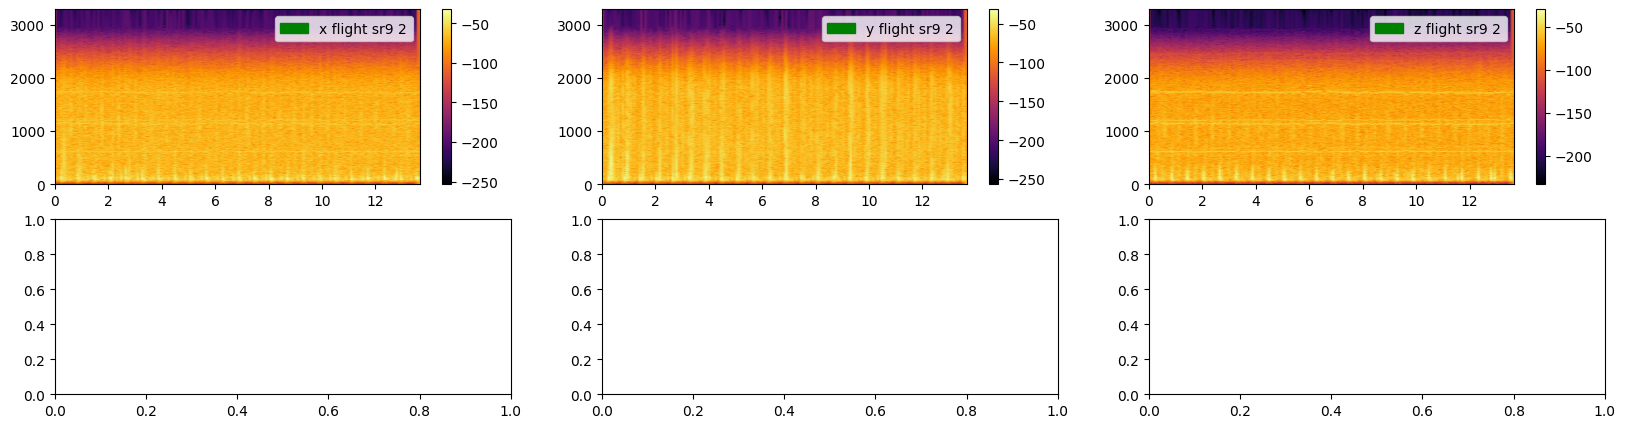

In [24]:
# plot the spectograms

if(use_mag):
    fig, ax = plt.subplots(1,2, figsize=(20, 5))
    c_scheme= "inferno"#"inferno" # viridis
    # shoe trial
    cax = ax[0].pcolormesh(s_stft[1], s_stft[0], s_stft[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[0])
    legend_patch = mpatches.Patch(color="green", label=f"{env} {s} {exp}")
    ax[0].legend(handles=[legend_patch])
    
    # barefoot trial
    #pcolormesh(t_stft, f, 10 * np.log10(np.abs(Zxx) ** 2), shading='gouraud', cmap='viridis')
    cax = ax[1].pcolormesh(b_stft[1], b_stft[0], b_stft[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[1])
    legend_patch = mpatches.Patch( label=f"{env} {b} {exp}")
    ax[1].legend(handles=[legend_patch])

else:
    fig, ax = plt.subplots(2,3, figsize=(20, 5)) # 2 rows 3 columns
    c_scheme= "inferno"#"inferno" # viridis
    # shoe trial
    cax = ax[0][0].pcolormesh(s_stft_x[1], s_stft_x[0], s_stft_x[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[0][0])
    legend_patch = mpatches.Patch(color="green", label=f"x {env} {s} {exp}")
    ax[0][0].legend(handles=[legend_patch])

    cax = ax[0][1].pcolormesh(s_stft_y[1], s_stft_y[0], s_stft_y[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[0][1])
    legend_patch = mpatches.Patch(color="green", label=f"y {env} {s} {exp}")
    ax[0][1].legend(handles=[legend_patch])

    cax = ax[0][2].pcolormesh(s_stft_z[1], s_stft_z[0], s_stft_z[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[0][2])
    legend_patch = mpatches.Patch(color="green", label=f"z {env} {s} {exp}")
    ax[0][2].legend(handles=[legend_patch])

    # barefoot trial
    cax = ax[1][0].pcolormesh(b_stft_x[1], b_stft_x[0], b_stft_x[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[1][0])
    legend_patch = mpatches.Patch(color="green", label=f"x {env} {b} {exp}")
    ax[1][0].legend(handles=[legend_patch])

    cax = ax[1][1].pcolormesh(b_stft_y[1], b_stft_y[0], b_stft_y[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[1][1])
    legend_patch = mpatches.Patch(color="green", label=f"y {env} {b} {exp}")
    ax[1][1].legend(handles=[legend_patch])

    cax = ax[1][2].pcolormesh(b_stft_z[1], b_stft_z[0], b_stft_z[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[1][2])
    legend_patch = mpatches.Patch(color="green", label=f"z {env} {b} {exp}")
    ax[1][2].legend(handles=[legend_patch])

    
    
    
    

In [48]:
# transfer fucntion -> divide the barefoot / shoes (shoes is the reference)
# PSD is better to do this with - use welch for this.
# by dividing them you get a model of the effect of removing the shoes
# describes the process of literally removing the shoes
# deeply personal model of them doing it and then push it into the transfer function -> it will tell us if the 
# "system" is changing

(0.0, 0.005)

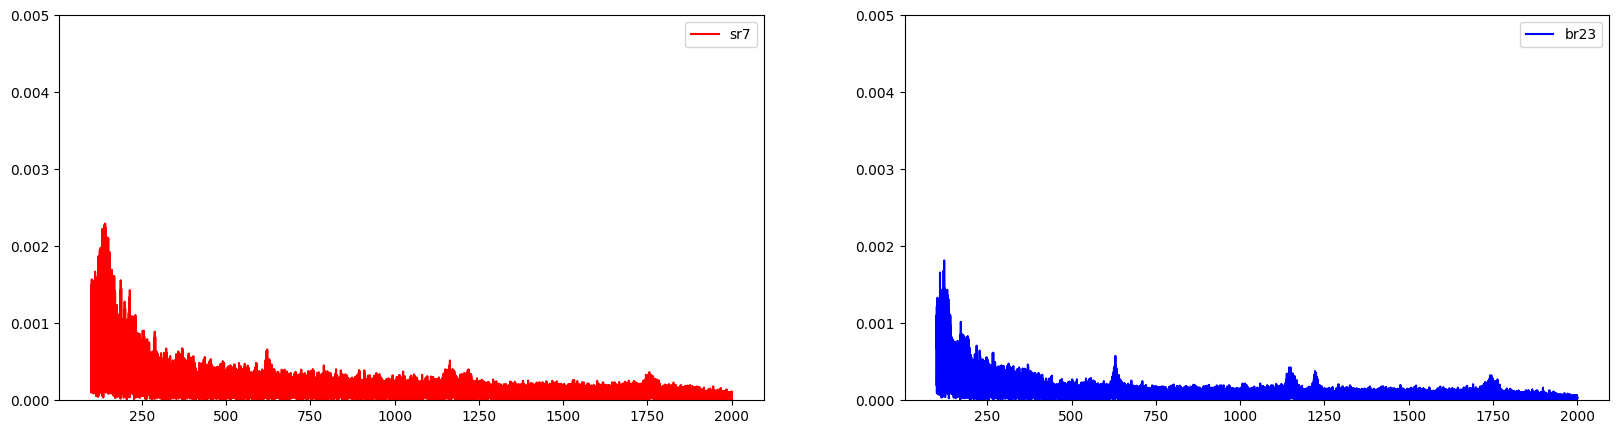

In [49]:
# test fft
s_fft_mag = h.compute_fft_mag(s_sig)
b_fft_mag = h.compute_fft_mag(b_sig)
s_graph = h.fft_graph_values(s_fft_mag, filter_params['sampling_rate'])
b_graph = h.fft_graph_values(b_fft_mag, filter_params['sampling_rate'])

s_freqs = np.array(s_graph[0])  # Convert list to a NumPy array
b_freqs = np.array(b_graph[0])
# Create a mask for the range
s_mask = (s_freqs >= filter_params["freq_min"]) & (s_freqs <= filter_params["freq_max"])
b_mask = (b_freqs >= filter_params["freq_min"]) & (b_freqs <= filter_params["freq_max"])
# Use the mask to filter frequencies and corresponding magnitudes
s_filtered_freqs = s_freqs[s_mask]
b_filtered_freqs = b_freqs[b_mask]

s_filtered_fft_mag  = np.array(s_graph[1])[s_mask]  
b_filtered_fft_mag  = np.array(b_graph[1])[b_mask] 


fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].plot(s_filtered_freqs, s_filtered_fft_mag, color="red", label=f"{s}")
ax[1].plot(b_filtered_freqs, b_filtered_fft_mag, color="blue", label=f"{b}")
ax[0].legend()
ax[0].set_ylim(0,0.005)
ax[1].legend()
ax[1].set_ylim(0,0.005)

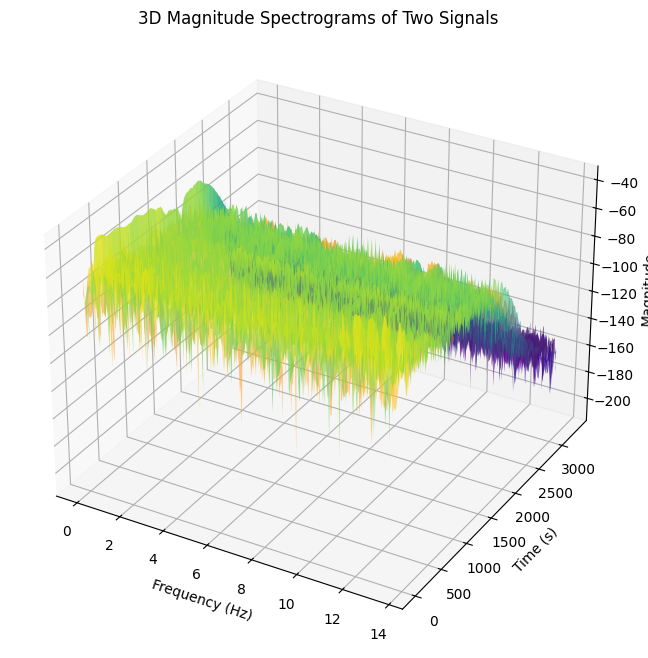

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import spectrogram

# Generate two example signals (e.g., different sine waves)

s_sig = np.array(s_sig)
b_sig = np.array(b_sig)


# Compute the spectrograms of both signals
f, t_spec, Sxx1 = spectrogram(s_sig, fs)
_, _, Sxx2 = spectrogram(b_sig, fs)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
#ax2 = fig.add_subplot(122, projection='3d')

# Plot the first signal's spectrogram
T1, F1 = np.meshgrid(t_spec, f)  # Create meshgrid for time and frequency
ax.plot_surface(T1, F1, 10 * np.log10(Sxx1), cmap='viridis', alpha=0.6)

# Plot the second signal's spectrogram
T2, F2 = np.meshgrid(t_spec, f)  # Create meshgrid for time and frequency
ax.plot_surface(T2, F2, 10 * np.log10(Sxx2), cmap='plasma', alpha=0.6)


# Labels and title
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Magnitude')
ax.set_title('3D Magnitude Spectrograms of Two Signals')



# Show the plot
plt.show()


Text(0, 0.5, 'Frequency [Hz]')

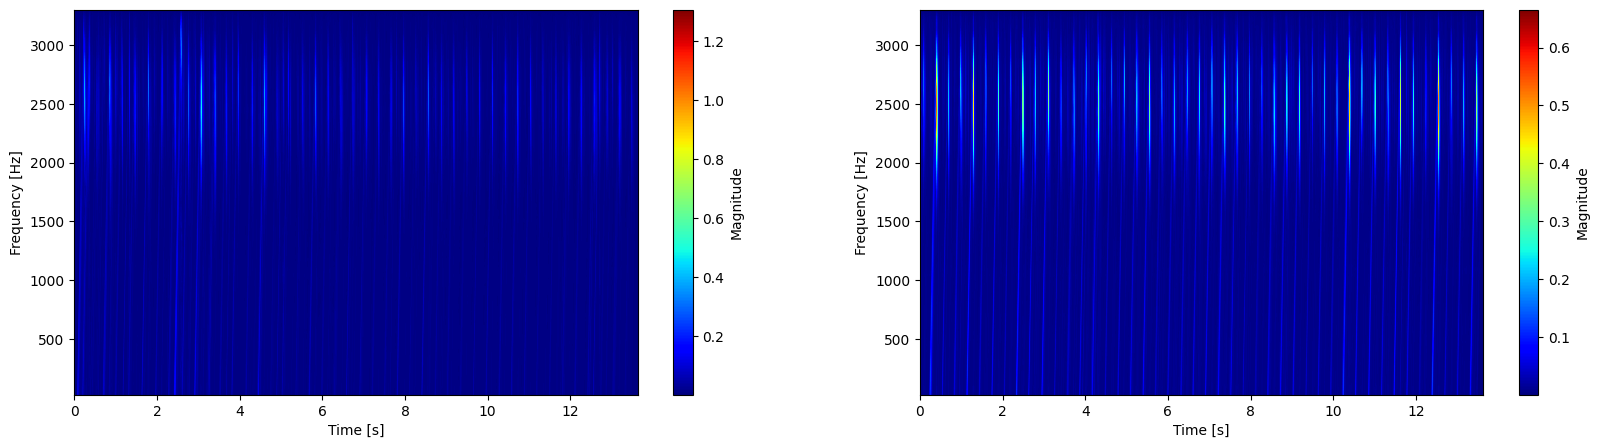

In [38]:
# what does CWT look like?

import numpy as np
import matplotlib.pyplot as plt
import pywt

# Generate a sample acceleration signal (for example, a sine wave)
# Replace this with your actual acceleration data
fs = filter_params["sampling_rate"]  # Sampling frequency (Hz)

t_s = np.arange(len(s_sig)) / fs  # Time vector
t_b = np.arange(len(b_sig)) / fs  # Time vector

# Apply Continuous Wavelet Transform (CWT)
# Choose a wavelet, for example, 'cmor' (complex Morlet wavelet)
scales = np.arange(1, 128)  # Define the range of scales for CWT
c_s, f_s = pywt.cwt(s_sig, scales, 'cmor', sampling_period=1/fs)
c_b, f_b = pywt.cwt(b_sig, scales, 'cmor', sampling_period=1/fs)

# Plot the spectrogram (wavelet transform result)
fig, ax = plt.subplots(1,2, figsize=(20, 5))
cax = ax[0].imshow(np.abs(c_s), aspect='auto', extent=[0, t_s[-1], f_s[-1], f_s[0]], cmap='jet')
fig.colorbar(cax, ax=ax[0], label='Magnitude')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Frequency [Hz]')

cax = ax[1].imshow(np.abs(c_b), aspect='auto', extent=[0, t_b[-1], f_b[-1], f_b[0]], cmap='jet')
#ax[1].colorbar(label='Magnitude')
fig.colorbar(cax, ax=ax[1], label='Magnitude')
#ax[1].title('Wavelet Transform Spectrogram')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Frequency [Hz]')

